In [13]:
import pandas as pd
import numpy as np

emb_df = pd.read_parquet("embeddings/train_esm2_embeddings.parquet")

def extract_uniprot_id(pid):
    parts = pid.split('|')
    if len(parts) >= 2:
        return parts[1]
    return pid

emb_df["protein_id"] = emb_df["protein_id"].apply(extract_uniprot_id)


In [14]:
BASE_DIR = "cafa-6-protein-function-prediction"
TRAIN_DIR = f"{BASE_DIR}/Train"
TEST_DIR = f"{BASE_DIR}/Test"

In [15]:
terms_df = pd.read_csv(f"{TRAIN_DIR}/train_terms.tsv", sep="\t")
# Each protein can appear multiple times — group all terms into a list
terms_grouped = (
    terms_df.groupby("EntryID")["term"]
    .apply(list)
    .reset_index()
    .rename(columns={"EntryID": "protein_id"})
)
print(terms_grouped.head())


   protein_id          term
0  A0A023FBW4  [GO:0019958]
1  A0A023FBW7  [GO:0019957]
2  A0A023FDY8  [GO:0019957]
3  A0A023FF81  [GO:0019958]
4  A0A023FFB5  [GO:0019957]


In [16]:
merged = emb_df.merge(terms_grouped, on="protein_id", how="inner")
print("Merged shape:", merged.shape)

X = merged.drop(columns=["protein_id", "term"]).astype(float).values
Y_raw = merged["term"]

from sklearn.preprocessing import MultiLabelBinarizer
import joblib

mlb = MultiLabelBinarizer(sparse_output=True)
Y = mlb.fit_transform(Y_raw)
joblib.dump(mlb, "mlb.pkl")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

from sklearn.model_selection import train_test_split

# Split into train (80%) and validation (20%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val shape:", X_val.shape, Y_val.shape)


Merged shape: (82404, 322)
X shape: (82404, 320)
Y shape: (82404, 26125)
Train shape: (65923, 320) (65923, 26125)
Val shape: (16481, 320) (16481, 26125)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ESM2HybridNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=1024, dropout=0.3):
        super().__init__()
        # --- CNN path ---
        self.conv = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        conv_out_dim = input_dim // 4 * 16  # after two pools (half each time)

        # --- MLP path ---
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # --- Fusion + output ---
        self.classifier = nn.Sequential(
            nn.Linear(conv_out_dim + hidden // 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, output_dim),
            nn.Sigmoid()  # explicit sigmoid like your working model
        )

    def forward(self, x):
        # CNN expects [B, 1, input_dim]
        cnn_feat = self.conv(x.unsqueeze(1))
        cnn_feat = torch.flatten(cnn_feat, 1)

        mlp_feat = self.mlp(x)
        fused = torch.cat([cnn_feat, mlp_feat], dim=1)
        return self.classifier(fused)


In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert sparse Y → dense (PyTorch cannot use sparse directly)
Y_train_dense = Y_train.toarray().astype("float32")
Y_val_dense   = Y_val.toarray().astype("float32")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_dense, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_dense, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)


Using device: cuda


In [23]:
model = ESM2HybridNet(input_dim=320, output_dim=26125).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
from sklearn.metrics import f1_score
import numpy as np

EPOCHS = 20

train_losses = []
val_losses = []
val_f1_scores = []

best_f1 = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    # ----------------------
    # Training
    # ----------------------
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

    # ----------------------
    # Validation
    # ----------------------
    model.eval()
    val_loss_sum = 0.0
    preds_list, true_list = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            out = model(xb)

            # loss
            val_loss_sum += criterion(out, yb).item()

            # threshold = 0.1 (DeepFRI style)
            preds_list.append((out > 0.1).cpu().numpy())
            true_list.append(yb.cpu().numpy())

    avg_val_loss = val_loss_sum / len(val_loader)
    val_losses.append(avg_val_loss)

    preds = np.vstack(preds_list)
    trues = np.vstack(true_list)
    f1 = f1_score(trues, preds, average="micro", zero_division=0)
    val_f1_scores.append(f1)

    print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_hybrid_model.pth")
        print(f"   ✅ New Best Model Saved (F1={best_f1:.4f})")

print(f"\n🎉 Final Best Validation F1 = {best_f1:.4f}")


[Epoch 1] Train Loss: 0.0304
[Epoch 1] Val Loss: 0.0018 | Val F1: 0.1610
   ✅ New Best Model Saved (F1=0.1610)
[Epoch 2] Train Loss: 0.0019
[Epoch 2] Val Loss: 0.0018 | Val F1: 0.1637
   ✅ New Best Model Saved (F1=0.1637)
[Epoch 3] Train Loss: 0.0018
[Epoch 3] Val Loss: 0.0018 | Val F1: 0.1631
[Epoch 4] Train Loss: 0.0018
[Epoch 4] Val Loss: 0.0018 | Val F1: 0.1657
   ✅ New Best Model Saved (F1=0.1657)
[Epoch 5] Train Loss: 0.0018
[Epoch 5] Val Loss: 0.0018 | Val F1: 0.1724
   ✅ New Best Model Saved (F1=0.1724)
[Epoch 6] Train Loss: 0.0018
[Epoch 6] Val Loss: 0.0017 | Val F1: 0.1791
   ✅ New Best Model Saved (F1=0.1791)
[Epoch 7] Train Loss: 0.0018
[Epoch 7] Val Loss: 0.0017 | Val F1: 0.1848
   ✅ New Best Model Saved (F1=0.1848)
[Epoch 8] Train Loss: 0.0017
[Epoch 8] Val Loss: 0.0017 | Val F1: 0.1898
   ✅ New Best Model Saved (F1=0.1898)
[Epoch 9] Train Loss: 0.0017
[Epoch 9] Val Loss: 0.0017 | Val F1: 0.1920
   ✅ New Best Model Saved (F1=0.1920)
[Epoch 10] Train Loss: 0.0017
[Epoch 10

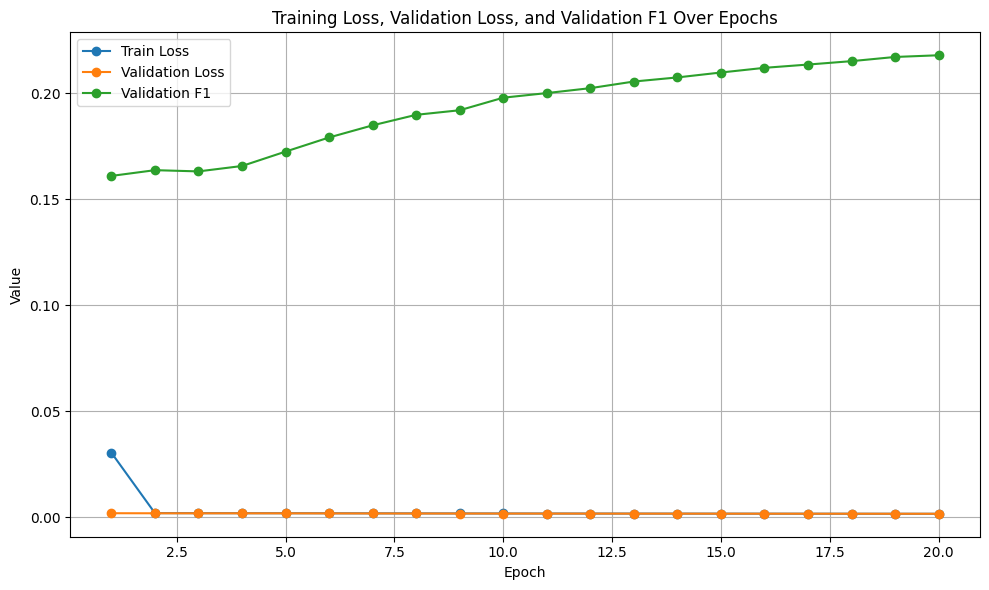

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.plot(epochs, val_f1_scores, label="Validation F1", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss, Validation Loss, and Validation F1 Over Epochs")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
test_emb_df = pd.read_parquet("embeddings/test_esm2_embeddings.parquet")

def extract_uniprot_id(pid):
    parts = pid.split('|')
    return parts[1] if len(parts) >= 2 else pid

test_emb_df["protein_id"] = test_emb_df["protein_id"].apply(extract_uniprot_id)
X_test = test_emb_df.drop(columns=["protein_id"]).astype(float).values
protein_ids = test_emb_df["protein_id"].values


In [27]:
import torch
import numpy as np
from tqdm import trange

# ======== CONFIG ========
batch_size = 256        # adjust based on GPU memory
threshold = 0.01        # only save scores above this (saves disk space)
outfile = "submission.tsv"
go_terms = mlb.classes_ # GO term order from training

# ======== Predict + Write ========
print(f"Generating predictions and saving to {outfile} ...")

with open(outfile, "w") as f_out:
    model.eval()
    with torch.no_grad():
        for i in trange(0, len(X_test), batch_size, desc="Predicting"):
            xb = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).to(device)
            probs = model(xb).cpu().numpy()          # shape: [batch, 26125]
            ids_batch = protein_ids[i:i+batch_size]  # UniProt IDs

            # Stream output to file
            for pid, row in zip(ids_batch, probs):
                high = row > threshold
                for go, p in zip(go_terms[high], row[high]):
                    f_out.write(f"{pid}\t{go}\t{p:.3f}\n")

print(f"\n✅ Submission saved to {outfile}")


Generating predictions and saving to submission.tsv ...


Predicting: 100%|██████████| 877/877 [00:17<00:00, 49.33it/s]


✅ Submission saved to submission.tsv


In [29]:
# protBERT + hybrid net
# Load ProtBERT embeddings
X_emb = np.load("embeddings/protbert_train.npy")
protbert_ids = np.load("embeddings/protbert_train_ids.npy", allow_pickle=True).astype(str)

emb_df = pd.DataFrame(X_emb)
emb_df["protein_id"] = protbert_ids

print("Embeddings loaded:", emb_df.shape)

Embeddings loaded: (82404, 1025)


In [32]:
merged = emb_df.merge(terms_grouped, on="protein_id", how="inner")
print("Merged shape:", merged.shape)

X = merged.drop(columns=["protein_id", "term"]).astype("float32").values
Y_raw = merged["term"]

from sklearn.preprocessing import MultiLabelBinarizer
import joblib

mlb = MultiLabelBinarizer(sparse_output=True)
Y = mlb.fit_transform(Y_raw)
joblib.dump(mlb, "mlb.pkl")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

from sklearn.model_selection import train_test_split

# Split into train (80%) and validation (20%)
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, Y_train.shape)
print("Val shape:", X_val.shape, Y_val.shape)


Merged shape: (82404, 1026)
X shape: (82404, 1024)
Y shape: (82404, 26125)
Train shape: (65923, 1024) (65923, 26125)
Val shape: (16481, 1024) (16481, 26125)


In [34]:
from torch.utils.data import Dataset

class SparseLabelDataset(Dataset):
    def __init__(self, X, Y_sparse):
        self.X = X.astype("float32")
        self.Y = Y_sparse  # scipy CSR matrix

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        # Convert ONLY this row to dense → shape (26125,) but small
        y = torch.tensor(self.Y[idx].toarray().ravel(), dtype=torch.float32)
        return x, y
train_dataset = SparseLabelDataset(X_train, Y_train)
val_dataset   = SparseLabelDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
from sklearn.metrics import f1_score

model = ESM2HybridNet(input_dim=X.shape[1], output_dim=Y.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 20
train_losses = []
val_losses = []
val_f1_scores = []
best_f1 = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------- Validation ----------------
    model.eval()
    total_val_loss = 0.0
    preds_list, true_list = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)

            total_val_loss += criterion(out, yb).item()
            preds_list.append((out > 0.1).cpu().numpy())
            true_list.append(yb.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    preds = np.vstack(preds_list)
    trues = np.vstack(true_list)
    f1 = f1_score(trues, preds, average="micro", zero_division=0)
    val_f1_scores.append(f1)

    print(f"[Epoch {epoch+1}] Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f} | F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_hybrid_protbert.pth")
        print(f"  ✅ Saved new best model (F1={best_f1:.4f})")

print("\nFinal Best F1:", best_f1)


Device: cuda
[Epoch 1] Train=0.0262 | Val=0.0018 | F1=0.1600
  ✅ Saved new best model (F1=0.1600)
[Epoch 2] Train=0.0019 | Val=0.0018 | F1=0.1697
  ✅ Saved new best model (F1=0.1697)
[Epoch 3] Train=0.0018 | Val=0.0017 | F1=0.1647
[Epoch 4] Train=0.0018 | Val=0.0017 | F1=0.1646
[Epoch 5] Train=0.0018 | Val=0.0017 | F1=0.1751
  ✅ Saved new best model (F1=0.1751)
[Epoch 6] Train=0.0017 | Val=0.0017 | F1=0.1782
  ✅ Saved new best model (F1=0.1782)
[Epoch 7] Train=0.0017 | Val=0.0017 | F1=0.1807
  ✅ Saved new best model (F1=0.1807)
[Epoch 8] Train=0.0017 | Val=0.0016 | F1=0.1906
  ✅ Saved new best model (F1=0.1906)
[Epoch 9] Train=0.0017 | Val=0.0016 | F1=0.1992
  ✅ Saved new best model (F1=0.1992)
[Epoch 10] Train=0.0016 | Val=0.0016 | F1=0.2041
  ✅ Saved new best model (F1=0.2041)
[Epoch 11] Train=0.0016 | Val=0.0016 | F1=0.2082
  ✅ Saved new best model (F1=0.2082)
[Epoch 12] Train=0.0016 | Val=0.0016 | F1=0.2105
  ✅ Saved new best model (F1=0.2105)
[Epoch 13] Train=0.0016 | Val=0.0016 |

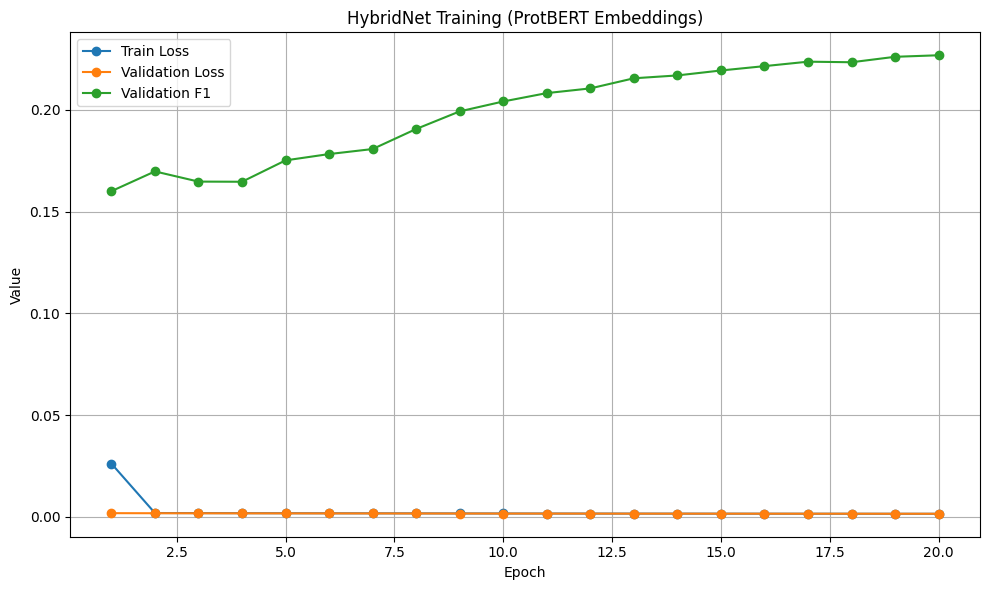

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.plot(epochs, val_f1_scores, label="Validation F1", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("HybridNet Training (ProtBERT Embeddings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import joblib
from torch.utils.data import DataLoader, TensorDataset

# -------------------------
# 0. Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# 1. Load ProtBERT test embeddings
# -------------------------
X_test = np.load("embeddings/protbert_test.npy")
test_ids = np.load("embeddings/protbert_test_ids.npy", allow_pickle=True).astype(str)

print("Loaded ProtBERT test set:")
print("  X_test shape:", X_test.shape)
print("  #test_ids:", len(test_ids))

# -------------------------
# 2. Load MultiLabelBinarizer
#    (use the one that was fit during ProtBERT training)
# -------------------------
mlb = joblib.load("mlb.pkl")  # change to "mlb.pkl" if that's what you used
go_terms = mlb.classes_
num_labels = len(go_terms)
print("Number of GO terms:", num_labels)

# -------------------------
# 3. Define HybridNet (same as training)
# -------------------------
class ESM2HybridNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=1024, dropout=0.3):
        super().__init__()
        # CNN path
        self.conv = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        conv_out_dim = (input_dim // 4) * 16

        # MLP path
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Fusion + output
        self.classifier = nn.Sequential(
            nn.Linear(conv_out_dim + hidden // 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, output_dim),
            nn.Sigmoid(),  # outputs in (0,1)
        )

    def forward(self, x):
        # x: (B, D)
        cnn_feat = self.conv(x.unsqueeze(1))  # (B, 1, D) -> conv
        cnn_feat = torch.flatten(cnn_feat, 1)
        mlp_feat = self.mlp(x)
        fused = torch.cat([cnn_feat, mlp_feat], dim=1)
        return self.classifier(fused)

# -------------------------
# 4. Load trained ProtBERT hybrid model
# -------------------------
input_dim = X_test.shape[1]
output_dim = num_labels

model = ESM2HybridNet(input_dim=input_dim, output_dim=output_dim).to(device)
model.load_state_dict(torch.load("best_hybrid_protbert.pth", map_location=device))
model.eval()

print("Loaded best_hybrid_protbert.pth")
print(model)

Using device: cuda
Loaded ProtBERT test set:
  X_test shape: (224309, 1024)
  #test_ids: 224309
Number of GO terms: 26125
Loaded best_hybrid_protbert.pth
ESM2HybridNet(
  (conv): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=26125, bias=Tr

In [9]:
import numpy as np
import torch
from tqdm import trange

# ===============================
# 1. Load ProtBERT npy embeddings
# ===============================
X_test = np.load("embeddings/protbert_test.npy")               # shape: (N, D)
protein_ids = np.load("embeddings/protbert_test_ids.npy",
                      allow_pickle=True).astype(str)

print("Loaded ProtBERT test set:", X_test.shape, len(protein_ids))

# ===============================
# 2. CONFIG
# ===============================
batch_size = 128
threshold = 0.01
outfile = "submission.tsv"
go_terms = mlb.classes_

# ===============================
# 3. PREDICTION + SUBMISSION
# ===============================

print(f"Generating predictions and saving to {outfile} ...")

with open(outfile, "w") as f_out:
    model.eval()
    with torch.no_grad():
        
        # Loop through test embeddings in batches
        for i in trange(0, len(X_test), batch_size, desc="Predicting"):
            
            # ---------------------------
            # ★ PREDICTION HAPPENS HERE ★
            # ---------------------------
            
            xb = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32).to(device)
            probs = model(xb).cpu().numpy()     # <-- ★ THIS IS WHERE PREDICTION OCCURS ★
            
            # ---------------------------

            ids_batch = protein_ids[i:i+batch_size]

            # Stream results to file
            for pid, row in zip(ids_batch, probs):
                high = row > threshold
                for go, p in zip(go_terms[high], row[high]):
                    f_out.write(f"{pid}\t{go}\t{p:.3f}\n")

print(f"\n✓ Submission saved to {outfile}")


Loaded ProtBERT test set: (224309, 1024) 224309
Generating predictions and saving to submission.tsv ...


Predicting: 100%|██████████| 1753/1753 [00:24<00:00, 71.40it/s] 


✓ Submission saved to submission.tsv


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# ===========================
# 1. LOAD ESM2 EMBEDDINGS
# ===========================
esm_emb = np.load("embeddings/esm2_embeddings.npy")     # shape (N, D)
esm_ids = np.load("embeddings/esm2_ids.npy")             # list of entry IDs

print("Loaded embeddings:", esm_emb.shape)
print("Loaded esm_ids:", len(esm_ids))

# Build fast lookup dict → entry_id → index in embedding matrix
id_to_index = {pid: i for i, pid in enumerate(esm_ids)}

# ===========================
# 2. LOAD CAFA TRAIN TERMS
# ===========================
terms_path = "cafa-6-protein-function-prediction/Train/train_terms.tsv"
train_terms = pd.read_csv(terms_path, sep="\t")

# Example structure:
# EntryID    GOTerm
# P12345     GO:0005524
# P12345     GO:0000166
print(train_terms.head())

# ===========================
# 3. GROUP GO TERMS PER PROTEIN
# ===========================
protein_to_go = (
    train_terms.groupby("EntryID")["term"].apply(list)
)

print("Number of training proteins:", len(protein_to_go))

# ===========================
# 4. MAP PROTEIN IDs → EMBEDDING INDEX
# ===========================
valid_proteins = []
valid_go_labels = []

missing = []

for pid, golist in protein_to_go.items():
    if pid in id_to_index:
        valid_proteins.append(pid)
        valid_go_labels.append(golist)
    else:
        missing.append(pid)

print("Mapped proteins:", len(valid_proteins))
print("Missing (train entries not found in embeddings):", len(missing))

# ===========================
# 5. BUILD X_train
# ===========================
X_train = np.vstack([esm_emb[id_to_index[pid]] for pid in valid_proteins])
print("X_train shape:", X_train.shape)

# ===========================
# 6. BUILD Y_train (Multi-label binary matrix)
# ===========================
mlb = MultiLabelBinarizer()
Y_train = mlb.fit_transform(valid_go_labels)

print("Y_train shape:", Y_train.shape)
print("Number of GO labels:", len(mlb.classes_))

# Save if needed
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("go_terms.npy", mlb.classes_)

print("Saved: X_train.npy, Y_train.npy, go_terms.npy")


Loaded embeddings: (224309, 1280)
Loaded esm_ids: 224309
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P
Number of training proteins: 82404
Mapped proteins: 82404
Missing (train entries not found in embeddings): 0
X_train shape: (82404, 1280)
Y_train shape: (82404, 26125)
Number of GO labels: 26125
Saved: X_train.npy, Y_train.npy, go_terms.npy


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Load data
X = np.load("X_train.npy")  # shape (N, EMBED_DIM)
Y = np.load("Y_train.npy")  # shape (N, num_classes)

X = X.astype(np.float32)
Y = Y.astype(np.float32)

print("X:", X.shape, "Y:", Y.shape)
class ESM2Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = ESM2Dataset(X_train, Y_train)
val_dataset   = ESM2Dataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)



X: (82404, 1280) Y: (82404, 26125)


In [18]:
num_classes = Y.shape[1]

model = ESM2HybridNet(
    input_dim=1280, 
    output_dim=num_classes, 
    hidden=2048, 
    dropout=0.3
).cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [19]:
from sklearn.metrics import f1_score

def multilabel_f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    return f1_score(y_true, y_pred, average="micro", zero_division=0)
import torch
import numpy as np

def train_model(model, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    val_f1_scores = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.cuda(), yb.cuda()

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # ---- Validation ----
        model.eval()
        val_loss = 0
        all_true = []
        all_pred = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.cuda(), yb.cuda()

                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()

                all_true.append(yb.cpu().numpy())
                all_pred.append(preds.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        y_true = np.vstack(all_true)
        y_pred = np.vstack(all_pred)
        f1 = multilabel_f1(y_true, y_pred)
        val_f1_scores.append(f1)

        print(f"Epoch {epoch}/{epochs} | Train Loss {train_losses[-1]:.4f} | "
              f"Val Loss {val_loss:.4f} | Val F1 {f1:.4f}")

    return train_losses, val_losses, val_f1_scores


In [20]:
train_losses, val_losses, val_f1_scores = train_model(model, train_loader, val_loader, epochs=20)


Epoch 1/20 | Train Loss 0.0093 | Val Loss 0.0018 | Val F1 0.0339
Epoch 2/20 | Train Loss 0.0018 | Val Loss 0.0017 | Val F1 0.0447
Epoch 3/20 | Train Loss 0.0018 | Val Loss 0.0017 | Val F1 0.0534
Epoch 4/20 | Train Loss 0.0017 | Val Loss 0.0017 | Val F1 0.0664
Epoch 5/20 | Train Loss 0.0017 | Val Loss 0.0016 | Val F1 0.0553
Epoch 6/20 | Train Loss 0.0016 | Val Loss 0.0015 | Val F1 0.0782
Epoch 7/20 | Train Loss 0.0015 | Val Loss 0.0015 | Val F1 0.0780
Epoch 8/20 | Train Loss 0.0015 | Val Loss 0.0015 | Val F1 0.0981
Epoch 9/20 | Train Loss 0.0014 | Val Loss 0.0015 | Val F1 0.1014
Epoch 10/20 | Train Loss 0.0014 | Val Loss 0.0014 | Val F1 0.1123
Epoch 11/20 | Train Loss 0.0013 | Val Loss 0.0014 | Val F1 0.1268
Epoch 12/20 | Train Loss 0.0013 | Val Loss 0.0014 | Val F1 0.1205
Epoch 13/20 | Train Loss 0.0012 | Val Loss 0.0014 | Val F1 0.1187
Epoch 14/20 | Train Loss 0.0012 | Val Loss 0.0014 | Val F1 0.1241
Epoch 15/20 | Train Loss 0.0011 | Val Loss 0.0014 | Val F1 0.1402
Epoch 16/20 | Train

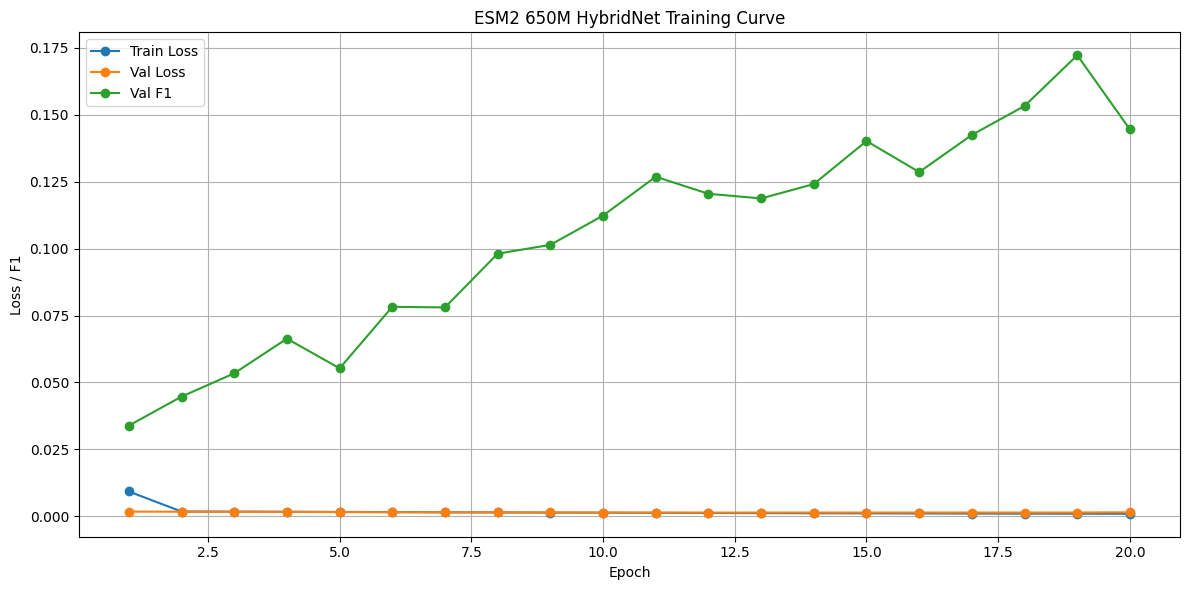

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,6))

plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.plot(epochs, val_f1_scores, label="Val F1", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Loss / F1")
plt.title("ESM2 650M HybridNet Training Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
